In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split as splits

# Part A: Data Setup

In [ ]:
# data preprocessing
df = pd.read_csv("https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/set4/data/COVID-19_Case_Surveillance_Public_Use_Data_Subset.csv")
df.drop(df[df["death_yn"] == "Missing"].index, inplace=True)
df.drop(df[df["death_yn"] == "Unknown"].index, inplace=True)
print(df.columns)

Index(['Unnamed: 0', 'cdc_case_earliest_dt ', 'cdc_report_dt', 'pos_spec_dt',
       'onset_dt', 'current_status', 'sex', 'age_group',
       'race_ethnicity_combined', 'hosp_yn', 'icu_yn', 'death_yn',
       'medcond_yn'],
      dtype='object')


In [ ]:
df.drop( 'medcond_yn', axis=1)
for date in ['cdc_case_earliest_dt ', 'cdc_report_dt', 'pos_spec_dt',
       'onset_dt']:
       df[date] = pd.to_datetime(df[date], infer_datetime_format=True).astype('int64')
       df[date]/df[date].max()

for i in [ 'current_status', 'sex', 'age_group',
       'race_ethnicity_combined', 'hosp_yn', 'icu_yn', 'Unnamed: 0', 'death_yn']:
       df[i] = pd.factorize(df[i])[0].astype('float')


<ipython-input-3-a495acd078a4>:4: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  df[date] = pd.to_datetime(df[date], infer_datetime_format=True).astype('int64')


In [ ]:
X = df.iloc[ : , : 11]
Y = df['death_yn']

X_train, X_test, Y_train, Y_test = splits(X, Y, test_size=0.20, shuffle=True)
print(len(X_train), len(X_test))

207772 51943


In [ ]:
# TODO: make sure your data can be converted to torch tensors
train_X = torch.tensor(X_train.values)
train_y = torch.tensor(Y_train.values)

test_X = torch.tensor(X_test.values)
test_y = torch.tensor(Y_test.values)


# make datasets and dataloaders
print()
train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True) 


# Part B: Linear Neural Network

## Model Setup

In [ ]:
model = nn.Sequential(nn.Linear(11, 5), nn.Linear(5, 1), nn.Sigmoid())
loss_f = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training Loop

In [ ]:
# Some layers, such as Dropout, behave differently during training

model.train()

for epoch in range(10):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Erase accumulated gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data.float())

        # Calculate loss
        target = target.unsqueeze(1)
        loss = loss_f(output, target.float())

        # Backward pass
        loss.backward()
        
        # Weight update
        optimizer.step()

    # Track loss each epoch
    print('Train Epoch: %d  Loss: %.4f' % (epoch + 1,  loss.item()))
# TODO: Write your training loop here.

Train Epoch: 1  Loss: 0.2500
Train Epoch: 2  Loss: 0.3750
Train Epoch: 3  Loss: 0.3393
Train Epoch: 4  Loss: 0.2500
Train Epoch: 5  Loss: 0.3393
Train Epoch: 6  Loss: 0.2500
Train Epoch: 7  Loss: 0.3214
Train Epoch: 8  Loss: 0.3214
Train Epoch: 9  Loss: 0.2500
Train Epoch: 10  Loss: 0.2857


## Testing Loop

In [ ]:
# Putting layers like Dropout into evaluation mode
model.eval()
test_loss = 0
correct = 0

# Turning off automatic differentiation
with torch.no_grad():
    for data, target in test_loader:
        output = model(data.float())
        test_loss += loss_f(output, (target.unsqueeze(1)).float()).item()  # Sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
        correct += pred.eq((target.unsqueeze(1)).view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
      (test_loss, correct, len(test_loader.dataset),
       100. * correct / len(test_loader.dataset)))

Test set: Average loss: 0.0090, Accuracy: 50600/51943 (97.4145)


## Weight Matrix Visualization

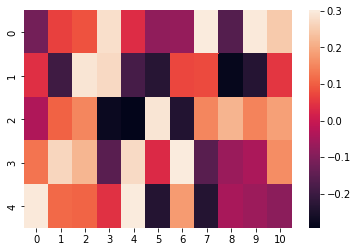

In [ ]:
weights = model.state_dict()['0.weight']

sns.heatmap(weights)

# Part C: 2-Layer Linear Model

In [ ]:
model2 = nn.Sequential(nn.Linear(11, 5), nn.Linear(5, 4), nn.Sigmoid(), nn.Linear(4, 3), nn.Linear(3, 1), nn.Sigmoid())

In [ ]:
# Some layers, such as Dropout, behave differently during training

model2.train()

for epoch in range(10):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Erase accumulated gradients
        optimizer.zero_grad()

        # Forward pass
        output = model2(data.float())

        # Calculate loss
        loss = loss_f(output, (target.unsqueeze(1)).float())

        # Backward pass
        loss.backward()
        
        # Weight update
        optimizer.step()

    # Track loss each epoch
    print('Train Epoch: %d  Loss: %.4f' % (epoch + 1,  loss.item()))
# TODO: Write your training loop here.

Train Epoch: 1  Loss: 0.1346
Train Epoch: 2  Loss: 0.1327
Train Epoch: 3  Loss: 0.1345
Train Epoch: 4  Loss: 0.1344
Train Epoch: 5  Loss: 0.1327
Train Epoch: 6  Loss: 0.1319
Train Epoch: 7  Loss: 0.1341
Train Epoch: 8  Loss: 0.1340
Train Epoch: 9  Loss: 0.1325
Train Epoch: 10  Loss: 0.1330


In [ ]:
# Putting layers like Dropout into evaluation mode
model2.eval()
test_loss = 0
correct = 0

# Turning off automatic differentiation
with torch.no_grad():
    for data, target in test_loader:
        output = model2(data.float())
        test_loss += loss_f(output, (target.unsqueeze(1)).float()).item()  # Sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
        correct += pred.eq((target.unsqueeze(1)).view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
      (test_loss, correct, len(test_loader.dataset),
       100. * correct / len(test_loader.dataset)))

Test set: Average loss: 0.0042, Accuracy: 50600/51943 (97.4145)


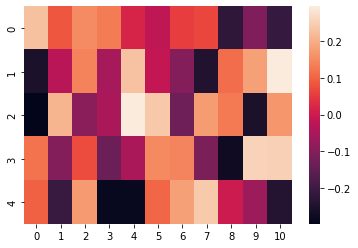

In [ ]:
weights = model2.state_dict()['0.weight']

sns.heatmap(weights)